# **Diagnóstico de enfermedades de tiroides usando clasificadores y muestras de pacientes tratados**


### Jhon Jaime Novoa - 2191711
### Miguel Espinel - 2191420
### Yerson Ibarra - 2190060


# **Introducción:**

En este notebook presentaremos un analisis sobre la clasificación de enfermedad de tiroides partiendo de un conjunto de datos demográficos y resultados de exámenes de sangre en diagnósticos de la enfermedad; aquella informacion nos sirvió de apoyo para implementar un clasificador que evalúe los datos de un paciente tal que nos de como resultado un diagnóstico que nos permita saber si este padece de deficiencia (hipotiroides) o sobreficiencia (hipertiroides) en su cuerpo, incluyendo la negación de ambos estados. Con esto en cuenta, se tomaron ciertas características comúnes en un diagnóstico y se usaron para el entrenamiento del modelo a usar.

La tiroides está definida en un par de hormonas importantes para los cambios de salubridad que puede tener una persona: la **T3 (triyodotironina)** que sería la encargada del manejo de funciones fisiológicas (que en exceso/ausencia causaría problemas graves al cuerpo), y seguido la **T4 (tiroxina)**, predecesor de la antes mencionada T3, que se encarga del apoyo a la hormona del crecimiento. Estas dos hormonas son la principal razón del sostenimiento de cuerpo, por lo que es importante saber con qué se relacionan para conocer datos que afecten de manera directa a la enfermedad.
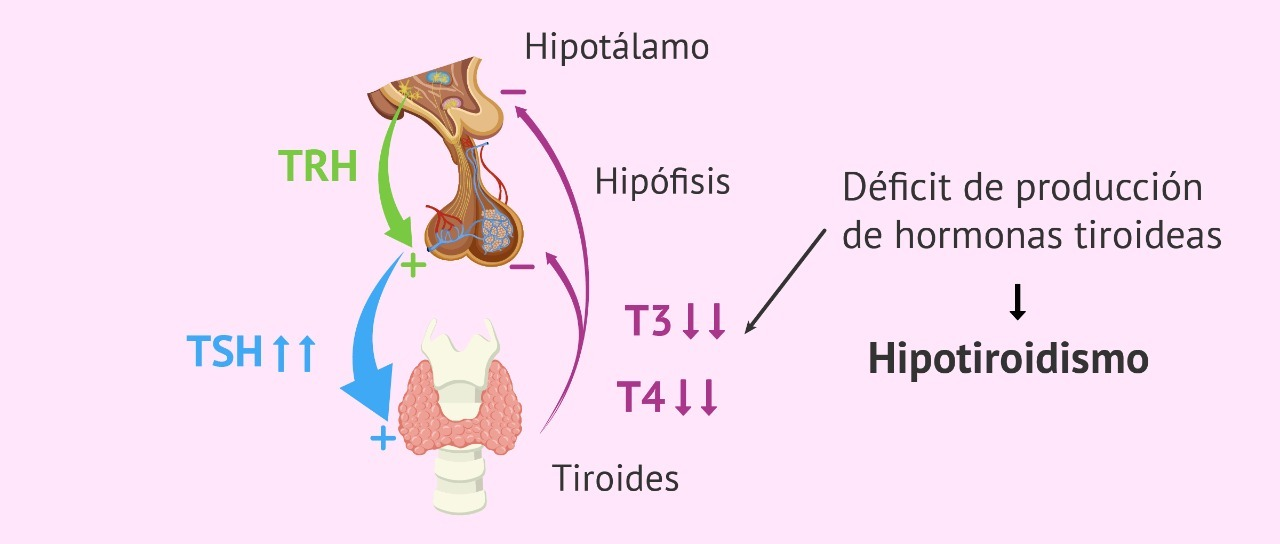

Entre estos datos conocemos la **TSH (Hormona Estimulante del Tiroides)** que está fuertemente ligada a la producción de hormonas tiroides. Se tiene también la **TGB (Globulina fijadora de tiroxina)** que maneja el almacenamiento de tiroxina para su debido transporte por la sangre; hay indicadores de exceso como el **FTI (Tiroxina libre)** que muestran la comparación que hay entre T4 y TGB para averiguar si los excesos son provocados por TGB (algo a tener muy en cuenta en el análisis), y por ultimo, está la **T4U** como una muestra de la compración y relación que tiene la T4 con la T3 para demostrar qué tan desbalanceados se encuentran los niveles de cada uno.
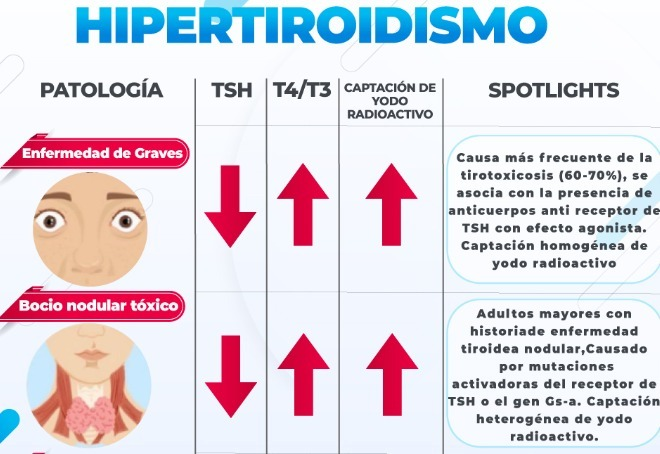

# **Análisis del dataset**

Para el analisis del dataset seleccionaremos la información antes dada y buscaremos relacionarlos entre ellos de alguna manera. Por definición, algunos ya están declarados de manera que se entiende directamente sus relaciones con respecto a todos los datos. Entre todo esto, podemos declarar que el dataset tiene en común el uso de pruebas y cantidades de hormonas como principales indicativos de medición, los cuales en ocasiones tienden a presentar alguna relación entre datos del mismo dataset. Cada parte de la información que se da comprende diferentes fases en las que la persona ha estado y además provee información acerca de que historial tiene con respecto al uso de medicamentos recetados, incluso en el historial de operaciones que tuvo el paciente.

En general hay mucha información relevante, pero lo que queremos realizar es un diagnóstico que nos defina el resultado de si porta o no la enfermedad que evaluamos. Por consecuencia, es claro decir que usaremos principalemte datos relacionados con la presencia de hormonas y también resultados de las pruebas que se realicen, ya que todos estos datos tienen relación unos con otros y además permiten concluir qué deficiencia/inflación posee el paciente.

In [1]:
# Librerías necesarias
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Cargando el data set
dataset = pd.read_csv('https://raw.githubusercontent.com/YHTM/ProyectIA/main/thyroidDF.csv')
dataset.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [3]:
# Análisis de todas las columnas
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

In [4]:
# Los datos de las tomas "XXX_measured" contienen informacion redundante. Se eliminan.
dataset.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured',
              'FTI_measured', 'TBG_measured', 'patient_id', 'referral_source'], axis=1, inplace=True)

# Con el fin de tener las tres clases a reconocer, se mapean todas las
# existentes para tener un estándar de los diagnósticos
dataset['target'] = dataset['target'].map(
    {
        '-': 'negativo',
        'A': 'hipertiroidismo', 
        'B': 'hipertiroidismo', 
        'C': 'hipertiroidismo', 
        'D': 'hipertiroidismo',
        'E': 'hipotiroidismo', 
        'F': 'hipotiroidismo', 
        'G': 'hipotiroidismo', 
        'H': 'hipotiroidismo'
    }
)

# Existen muestras con valores nulos, por lo cual se hace una limpieza de
# estos registros
dataset.dropna(subset=['target', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'], inplace=True)

# Se cambian los valores de las edades mayores a 150 como nulas
# y se eliminan (un total de 3 registros)
dataset['age'] = np.where((dataset.age > 150), np.nan, dataset.age)
dataset.dropna(subset=['age'], inplace=True)

In [5]:
dataset.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,TBG,target
19,36.0,F,f,f,f,f,f,f,f,t,...,f,f,f,1.50,2.4,90.0,1.06,85.0,NaN,negativo
21,40.0,F,f,f,f,f,f,f,f,f,...,f,f,f,1.20,2.3,104.0,1.08,96.0,NaN,negativo
22,40.0,F,f,f,f,f,f,f,f,f,...,f,f,f,5.90,2.1,88.0,0.84,105.0,NaN,negativo
23,77.0,F,f,f,f,f,f,f,f,f,...,f,f,f,0.05,2.4,107.0,1.13,95.0,NaN,negativo
27,51.0,F,f,f,f,f,f,f,f,f,...,f,f,f,0.05,2.1,93.0,0.87,106.0,NaN,negativo


In [6]:
dataset.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG
count,4656.000000,4656.000000,4656.000000,4656.000000,4656.000000,4656.000000,17.000000
mean,53.155284,5.419060,1.998484,105.194858,0.975604,109.222141,27.705882
std,18.376705,26.724083,0.784652,33.470741,0.161417,34.801290,7.547886
min,1.000000,0.005000,0.050000,2.000000,0.250000,1.400000,15.000000
25%,38.000000,0.497500,1.600000,88.000000,0.870000,93.000000,22.000000
50%,56.000000,1.300000,1.900000,103.000000,0.970000,107.000000,27.000000
75%,68.000000,2.500000,2.300000,121.000000,1.060000,124.000000,32.000000
max,97.000000,530.000000,18.000000,430.000000,2.120000,642.000000,45.000000


Los datos a usar como características para este escenario son: 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG'

Vemos algunos datos inconsistentes como la edad ya que vemos que su valor máximo es de 65526, por lo cual se hace un manejo de este dato:

In [7]:
# Correlación de los datos con los que se va a trabajar
dataset[['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG', 'target']].corr()

,TSH,T3,TT4,T4U,FTI,TBG
TSH,1.000000,-0.199182,-0.332727,0.106572,-0.344877,-0.085407
T3,-0.199182,1.000000,0.582655,0.180418,0.520249,0.330916
TT4,-0.332727,0.582655,1.000000,0.287776,0.845413,-0.040025
T4U,0.106572,0.180418,0.287776,1.000000,-0.225840,0.577396
FTI,-0.344877,0.520249,0.845413,-0.225840,1.000000,-0.289191
TBG,-0.085407,0.330916,-0.040025,0.577396,-0.289191,1.000000


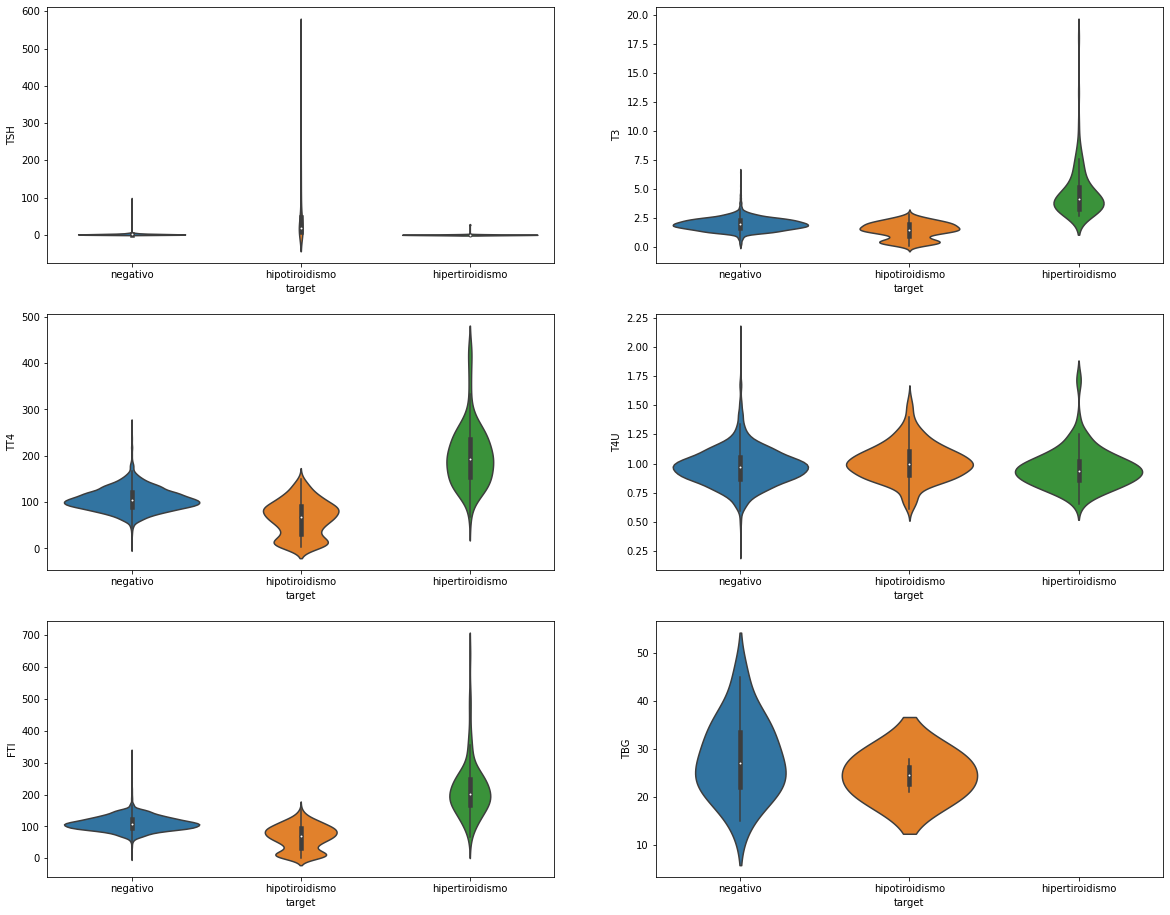

In [8]:
# Distribuciones del 'TSH', 'T3', 'TT4', 'T4U', 'FTI' vs target (clases)
import seaborn as sns
y = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
fig, axes = plt.subplots(3,2,figsize=(20,16))
axes=[axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1]]
dicc = dict(zip(y, axes))

for clave, valor in dicc.items():
  sns.violinplot(x="target", y=clave, data=dataset, ax=valor)


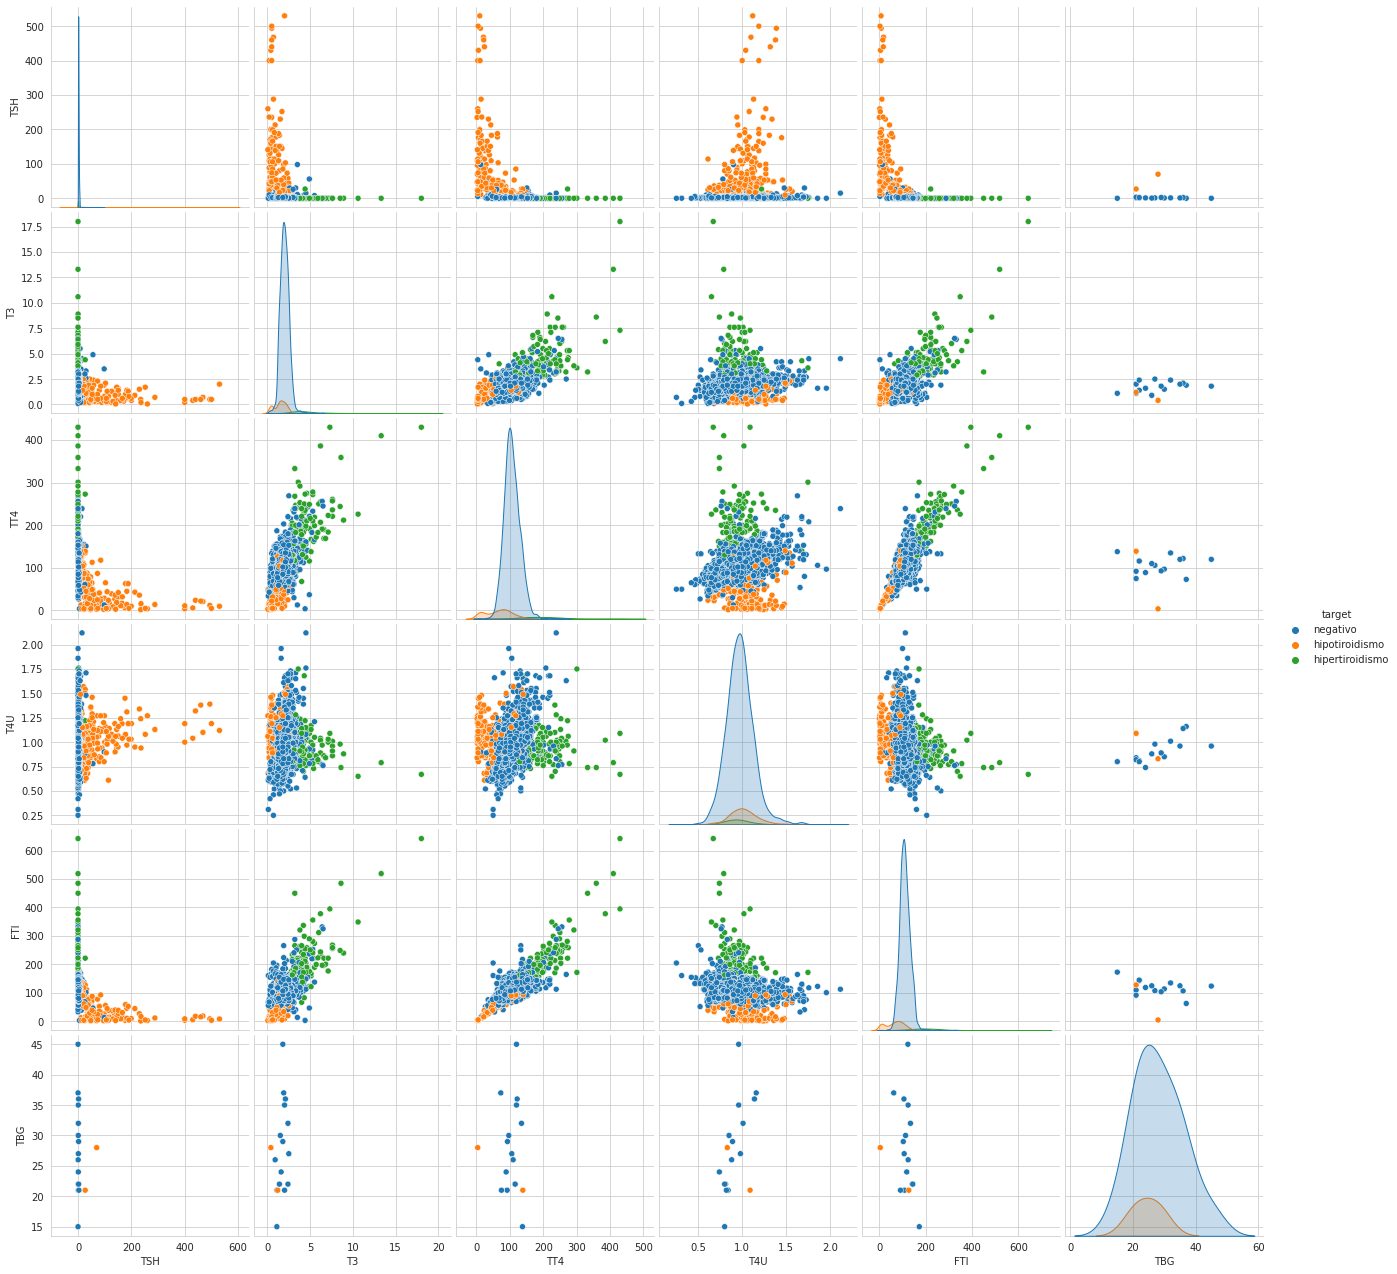

In [9]:
sns.set_style('whitegrid');
sns.pairplot(dataset[['TSH', 'T3', 'TT4', 'T4U', 'FTI','TBG', 'target']], hue='target', height=3);
plt.show()

Vemos que algunos de estos datos se separan bien en cuanto a nuestro target, lo cual se ve muy bien para la clasificacion que queremos realizar en el target

In [10]:
dataframe = dataset.select_dtypes(include='object')
dataframe['sex'] = dataframe['sex'].map({'F' : 0, 'M' : 1})
# to get all the columns except the sex & target
cols = dataframe.loc[:, ~dataframe.columns.isin(['sex','target','referral_source'])] 
for c in cols:
    dataframe[c] = dataframe[c].map({'f' : 0, 't' : 1})
dataframe['age'] = dataset['age']
dataframe['TT4'] = dataset['TT4']
dataframe['T4U'] = dataset['T4U'] 
dataframe['FTI'] = dataset['FTI']
dataframe['TSH'] = dataset['TSH']
dataframe['T3'] = dataset['T3']
dataframe['TBG'] = dataset['TBG']
dataframe['target'] = dataset['target']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [11]:
dataframe['target'] = dataframe['target'].map(
    {
        'negativo': 0,
        'hipotiroidismo': 2,
        'hipertiroidismo': 1
    }
)

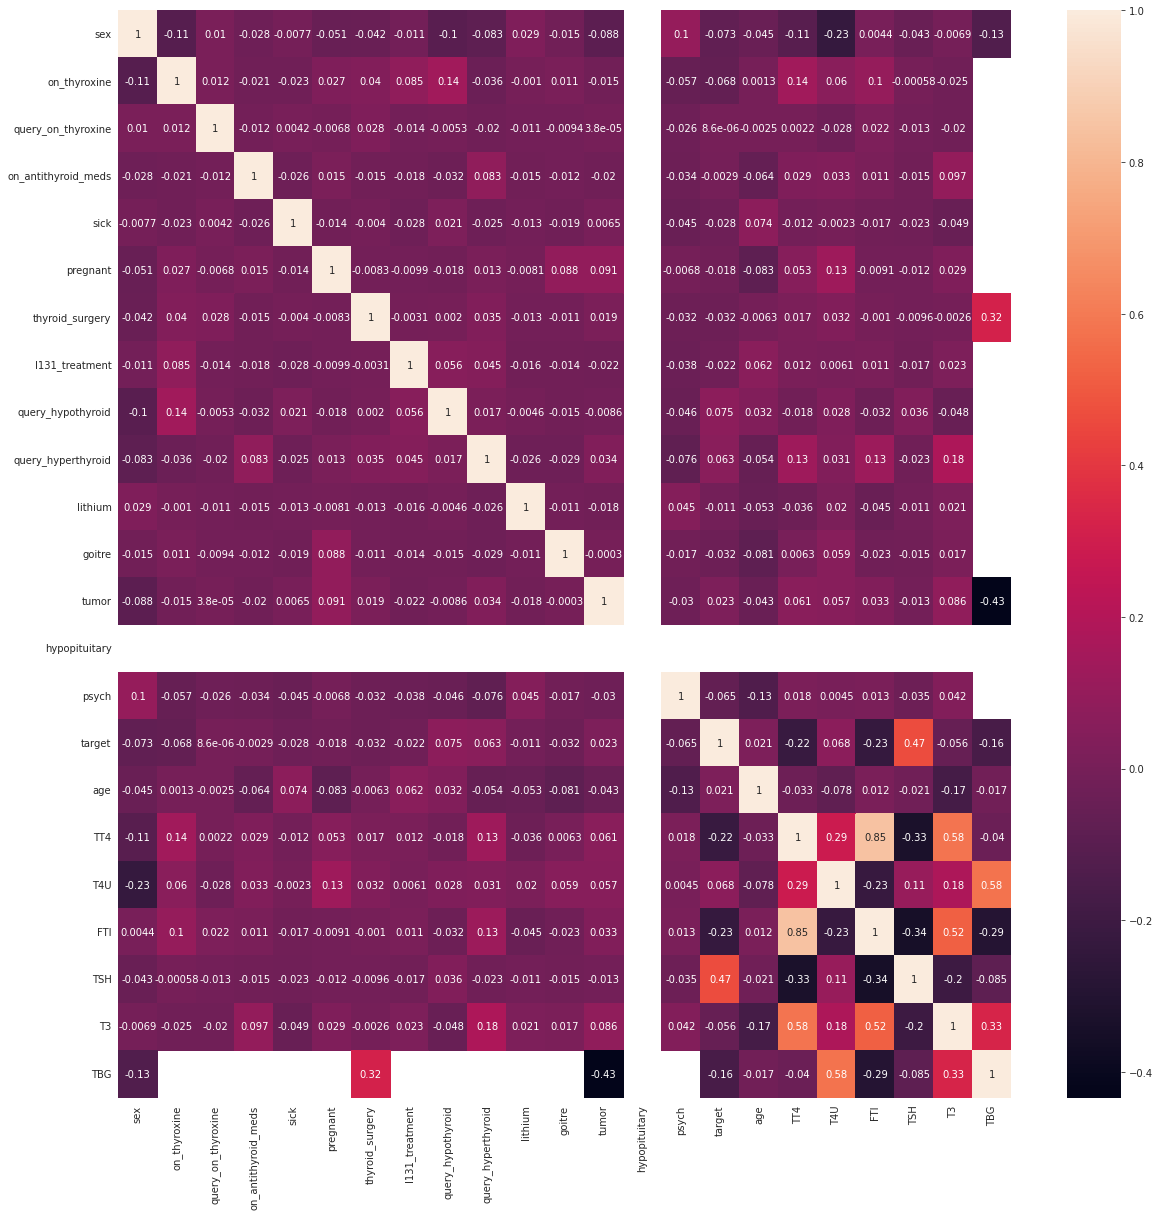

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = dataframe.corr(method='pearson')

plt.figure(figsize=(20, 20))
sns.heatmap(corr_df, annot=True)
plt.show()

Metodos para clasificacion

Vamos a usar solo las mediciones de hormonas para realizar el clasificador

## **Decision Tree**

In [13]:
#import numpy as np
#se realizo utilizando todos los datos de hormonas
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

muestras = ['T4U', 'T3', 'TT4', 'FTI', 'TSH', 'TBG']
casos =[]
for i in range(len(muestras)):
  casos.append(muestras[0:i+1])

for muestras in casos:
  seccion = dataframe[muestras+['target']]
  for muestra in muestras:
    seccion.dropna(subset=[muestra], inplace=True)
  X = seccion[muestras]
  y = seccion['target']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=21)
  est = DecisionTreeClassifier(random_state=21)
  est.fit(X_train,y_train)
  pred = est.predict(X_test)
  print('muestras usadas: ',muestras)
  print('accuracy score: ', accuracy_score(pred, y_test))
  print('\n')


muestras usadas:  ['T4U']
accuracy score:  0.8927038626609443


muestras usadas:  ['T4U', 'T3']
accuracy score:  0.8658798283261803


muestras usadas:  ['T4U', 'T3', 'TT4']
accuracy score:  0.8873390557939914


muestras usadas:  ['T4U', 'T3', 'TT4', 'FTI']
accuracy score:  0.8776824034334764


muestras usadas:  ['T4U', 'T3', 'TT4', 'FTI', 'TSH']
accuracy score:  0.9753218884120172


muestras usadas:  ['T4U', 'T3', 'TT4', 'FTI', 'TSH', 'TBG']
accuracy score:  0.75




/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/

## **RandomForest**

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


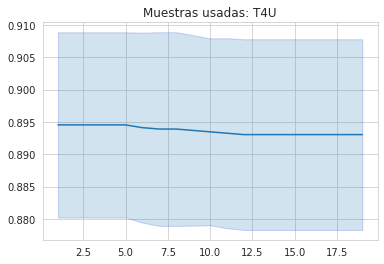

Máximo:  0.8945415109142093


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


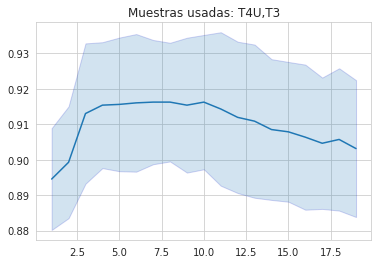

Máximo:  0.9162296368083437


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


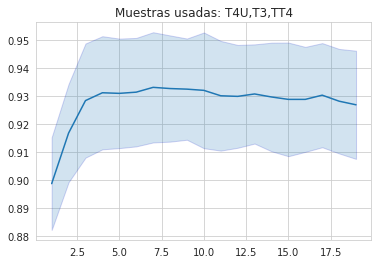

Máximo:  0.9331935022382206


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


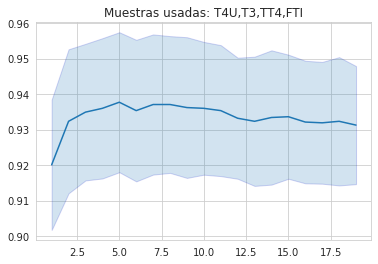

Máximo:  0.9377059393603766


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


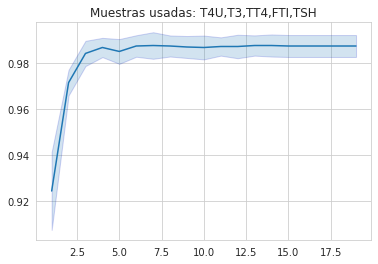

Máximo:  0.9875393419170242


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


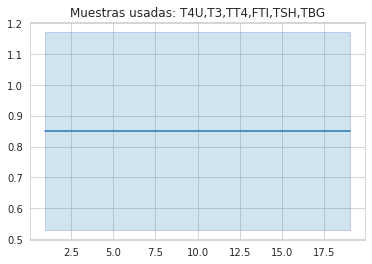

Máximo:  0.85


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import numpy as np

muestras = [ 'T4U', 'T3', 'TT4', 'FTI', 'TSH', 'TBG']
casos = []
for i in range(len(muestras)):
  casos.append(muestras[0:i+1])

for muestras in casos:
  seccion = dataframe[muestras+['target']]
  for muestra in muestras:
    seccion.dropna(subset=[muestra], inplace=True)
  X = seccion[muestras]
  y = seccion['target']
  lista_ap = []
  lista_astd = []
  for i in range(1,20):
    est = RandomForestClassifier(max_depth=i,n_estimators=20,random_state=21)
    s = cross_val_score(est, X, y, cv=KFold(10, shuffle=False), scoring=make_scorer(accuracy_score))
    lista_ap.append(np.mean(s))
    lista_astd.append(np.std(s))

  plt.plot(range(1, 20, 1), lista_ap)
  plt.fill_between(range(1, 20, 1), np.array(lista_ap)-np.array(lista_astd), np.array(lista_ap)+np.array(lista_astd), alpha=0.2, edgecolor='#1B2ACC')
  plt.title('Muestras usadas: '+','.join(muestras))
  plt.show()
  print('Máximo: ',max(lista_ap))



SVC

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


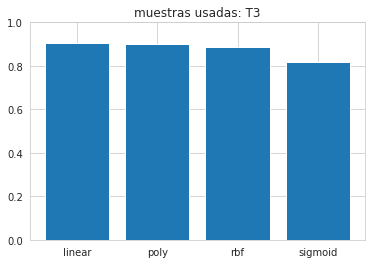

Máximo:  0.9066523605150214


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


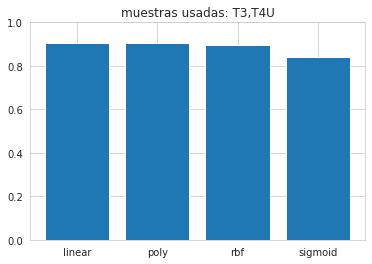

Máximo:  0.9055793991416309


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


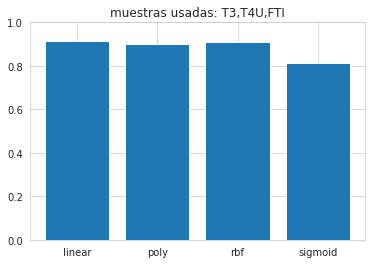

Máximo:  0.9152360515021459


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


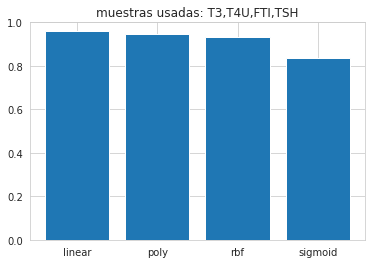

Máximo:  0.9613733905579399


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


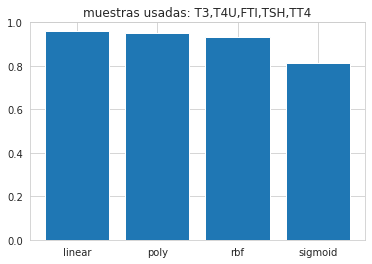

Máximo:  0.9624463519313304


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


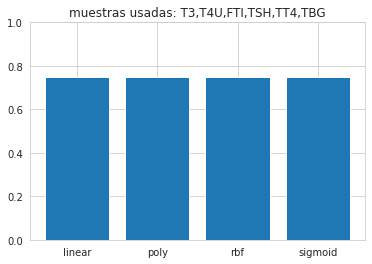

Máximo:  0.75


In [15]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


muestras = ['T3', 'T4U', 'FTI', 'TSH', 'TT4', 'TBG']
casos = []
for i in range(len(muestras)):
  casos.append(muestras[0:i+1])

for muestras in casos:
  seccion = dataframe[muestras+['target']]
  for muestra in muestras:
    seccion.dropna(subset=[muestra], inplace=True)
  X = seccion[muestras]
  y = seccion['target']
  list_a = []
  kernels = ['linear', 'poly', 'rbf', 'sigmoid']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, shuffle=False)
  for i in kernels:
    est = SVC(random_state=21,kernel=i)
    est.fit(X_train,y_train)
    list_a.append(accuracy_score(est.predict(X_test), y_test))

  plt.bar(kernels, list_a, width=0.8)
  plt.ylim(0, 1)
  plt.title('muestras usadas: '+','.join(muestras))
  plt.show()
  print('Máximo: ',max(list_a))

# **Conclusiones**
Se tiene entonces un breve estudio de cómo partiendo de datos sacados de diagnósticos de enfermedad de tiroides se puede usar la inteligencia artificial para implementar modelos computacionales que sirvan de ayuda en otros campos (como la medicina) para agilizar y mejorar las actividades de investigación, análisis y diagnóstico en personas con posibles padecimientos de enfermedades y condiciones clínicas. El uso de estas herramientas se puede extender aún más y, en el análisis de enfermedad de tiroides, podemos ampliar este estudio de clasificación y diagnóstico al pensar en el uso de resultados de ultrasonidos en pacientes con diagnóstico de tiroides como datos gráficos (imágenes) para la implementación de modelos de aprendizaje profundo (redes neuronales) los cuales puedan servir como herramientas adicionales para tener mayor seguridad y veracidad al detectar casos de la enfermedad en pacientes.